In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# Introduction

In [2]:
data = pd.read_csv('Dataset/emergency_classification.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       2352 non-null   object
 1   emergency_or_not  2352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.9+ KB


In [4]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [5]:
data['emergency_or_not'].value_counts()

0    1361
1     991
Name: emergency_or_not, dtype: int64

In [6]:
X = []
for image_name in data['image_names']:
    img = plt.imread('Dataset/images/'+image_name)
    X.append(img)
X = np.array(X)

In [7]:
X.shape

(2352, 224, 224, 3)

In [8]:
y = data['emergency_or_not']

In [9]:
y.shape

(2352,)

In [10]:
rng = np.random.default_rng()

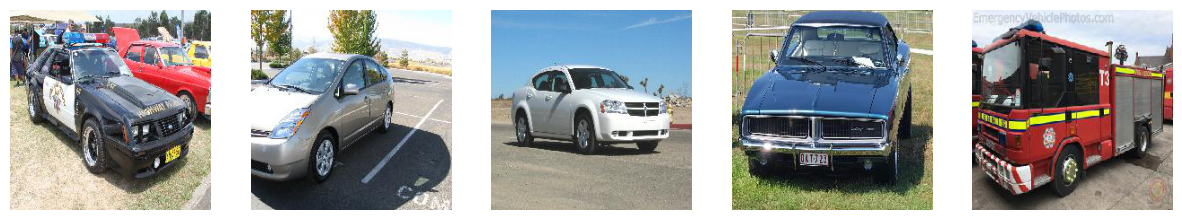

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,20))
for i in range(5):
    ax[i].imshow(X[rng.integers(X.shape[0])])
    ax[i].axis('off')

# Processing

In [12]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

In [13]:
X.shape

(2352, 150528)

In [14]:
X.min(), X.max()

(0, 255)

In [15]:
X = X / X.max()

In [16]:
X.min(), X.max()

(0.0, 1.0)

In [17]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, det_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [19]:
X_train.shape, X_test.shape

((1646, 150528), (706, 150528))

# Model

In [25]:
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [72]:
model=Sequential()
model.add(Dense(units=100, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [73]:
# summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [75]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [77]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 4s 247ms/step - loss: 0.6358 - binary_accuracy: 0.6391 - val_loss: 0.6382 - val_binary_accuracy: 0.6317
Epoch 2/50
13/13 [==============================] - 3s 215ms/step - loss: 0.6234 - binary_accuracy: 0.6470 - val_loss: 0.6016 - val_binary_accuracy: 0.6728
Epoch 3/50
13/13 [==============================] - 3s 250ms/step - loss: 0.6235 - binary_accuracy: 0.6567 - val_loss: 0.6033 - val_binary_accuracy: 0.6686
Epoch 4/50
13/13 [==============================] - 3s 235ms/step - loss: 0.6048 - binary_accuracy: 0.6695 - val_loss: 0.5895 - val_binary_accuracy: 0.6926
Epoch 5/50
13/13 [==============================] - 3s 234ms/step - loss: 0.5982 - binary_accuracy: 0.6829 - val_loss: 0.5829 - val_binary_accuracy: 0.6941
Epoch 6/50
13/13 [==============================] - 3s 197ms/step - loss: 0.5673 - binary_accuracy: 0.7303 - val_loss: 0.6162 - val_binary_accuracy: 0.6586
Epoch 7/50
13/13 [==============================] - 2s 194ms/ste

In [78]:
model = load_model('vehicle_model.h5')

In [79]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 24ms/step


In [80]:
prediction_cat = (prediction >= 0.5).astype(int)

In [81]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.72      0.84      0.78       396
           1       0.74      0.59      0.65       310

    accuracy                           0.73       706
   macro avg       0.73      0.71      0.72       706
weighted avg       0.73      0.73      0.72       706



In [82]:
history_df = pd.DataFrame(history.history)

In [83]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.635817,0.639125,0.638182,0.631728
1,0.623386,0.647023,0.601603,0.672805
2,0.623544,0.656744,0.603270,0.668555
3,0.604784,0.669502,0.589516,0.692635
4,0.598193,0.682868,0.582948,0.694051


In [84]:
pd.melt(history_df.reset_index(), id_vars='index')

,index,variable,value
0,0,loss,0.635817
1,1,loss,0.623386
2,2,loss,0.623544
3,3,loss,0.604784
4,4,loss,0.598193
...,...,...,...
195,45,val_binary_accuracy,0.728045
196,46,val_binary_accuracy,0.678470
197,47,val_binary_accuracy,0.723796
198,48,val_binary_accuracy,0.726629


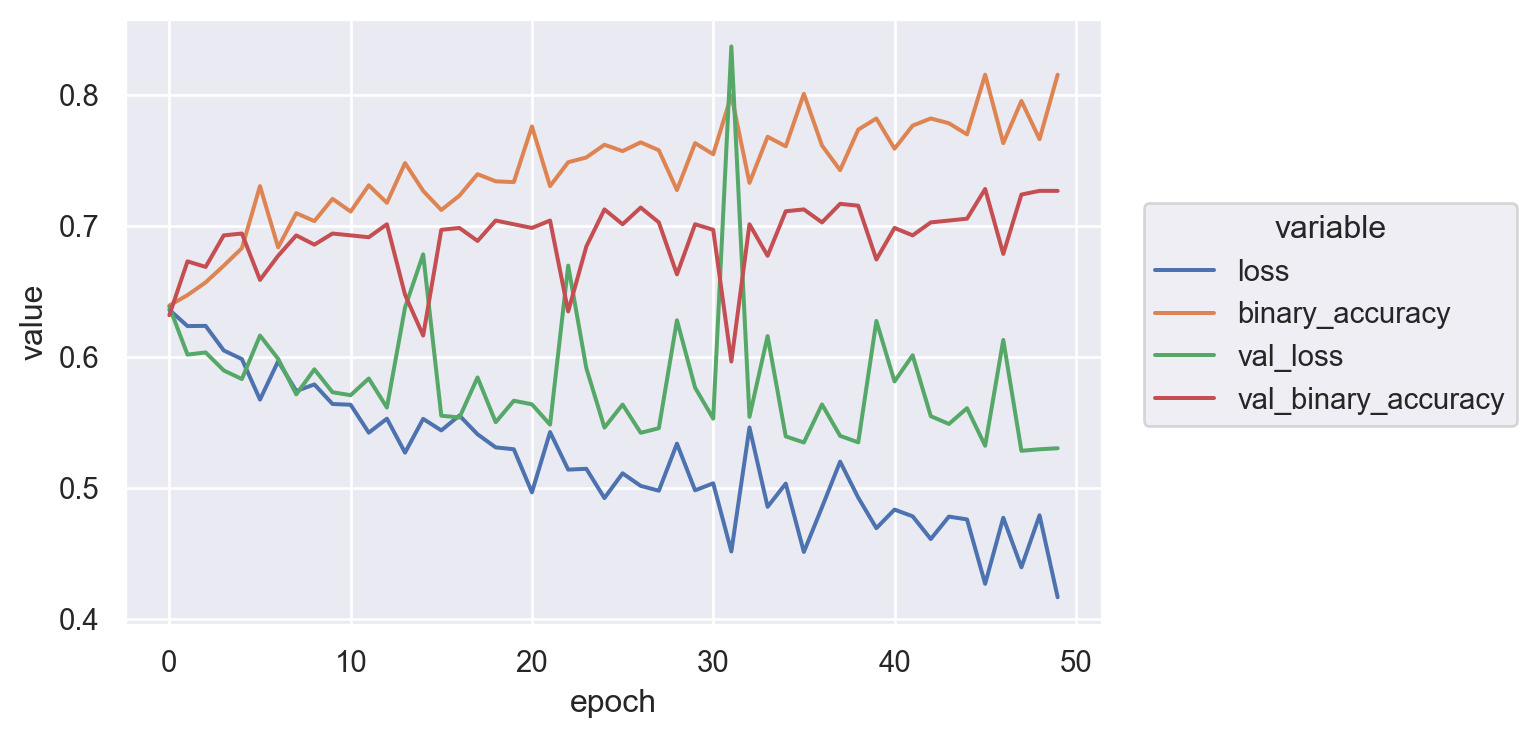

In [85]:
so.Plot(pd.melt(history_df.reset_index(), id_vars='index'), x='index', y='value', 
        color='variable').add(so.Line()).label(x='epoch').layout(size=(6,4))

Text(0.5, 0.01, 'epochs')

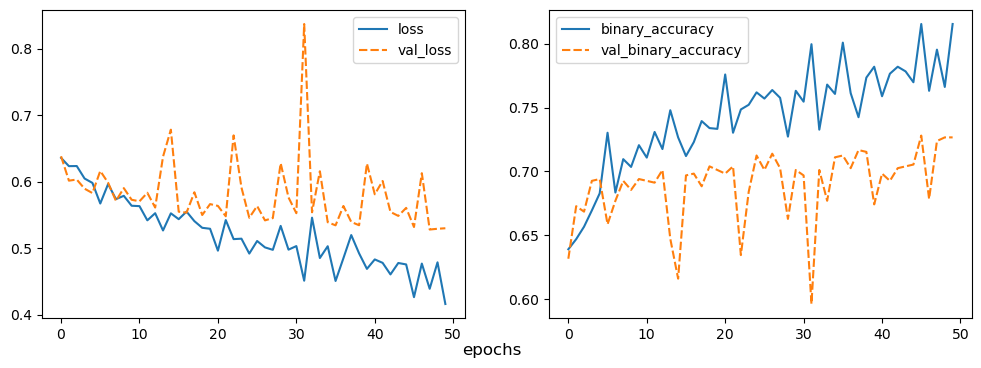

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 0, predicted probability 0.6777545809745789


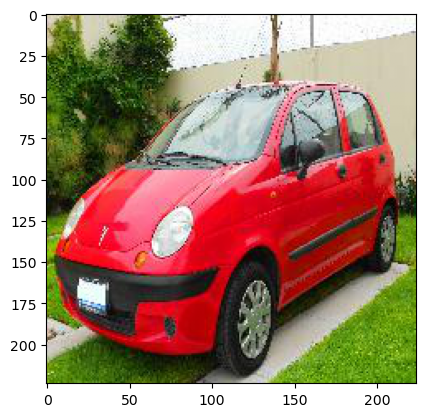

In [87]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X_test[index], (224,224,3)))
print(f'actual class {y_test.iloc[index]}, predicted probability {prediction[index][0]}')

# Hyper parameter tuning

## change activation function

In [106]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [107]:
# summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               15052900  
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.compile(optimizer=keras.optimizers.SGD(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [109]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [110]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 7s 516ms/step - loss: 1.7418 - binary_accuracy: 0.5450 - val_loss: 0.6723 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 3s 199ms/step - loss: 0.6556 - binary_accuracy: 0.6136 - val_loss: 0.6638 - val_binary_accuracy: 0.5652
Epoch 3/50
13/13 [==============================] - 3s 237ms/step - loss: 0.6437 - binary_accuracy: 0.6330 - val_loss: 0.6390 - val_binary_accuracy: 0.6686
Epoch 4/50
13/13 [==============================] - 3s 241ms/step - loss: 0.6363 - binary_accuracy: 0.6367 - val_loss: 0.6173 - val_binary_accuracy: 0.6756
Epoch 5/50
13/13 [==============================] - 3s 254ms/step - loss: 0.6144 - binary_accuracy: 0.6707 - val_loss: 0.6023 - val_binary_accuracy: 0.6841
Epoch 6/50
13/13 [==============================] - 2s 189ms/step - loss: 0.6148 - binary_accuracy: 0.6738 - val_loss: 0.6013 - val_binary_accuracy: 0.6912
Epoch 7/50
13/13 [==============================] - 2s 164ms/ste

In [111]:
model = load_model('vehicle_model.h5')

In [112]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 23ms/step


In [113]:
prediction_cat = (prediction >= 0.5).astype(int)

In [114]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       396
           1       0.71      0.61      0.65       310

    accuracy                           0.72       706
   macro avg       0.71      0.70      0.71       706
weighted avg       0.72      0.72      0.71       706



In [115]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

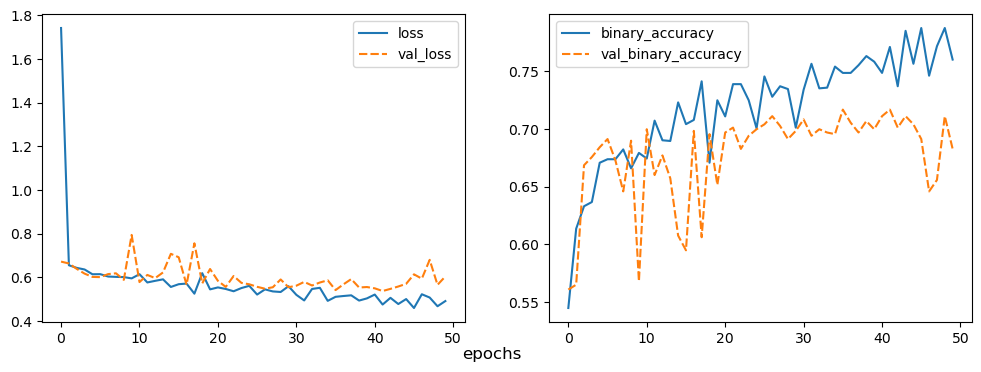

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## change optimizer

In [117]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=1, activation='sigmoid'))

In [118]:
# summary of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               15052900  
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,053,001
Trainable params: 15,053,001
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [120]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [121]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 9s 655ms/step - loss: 27.5326 - binary_accuracy: 0.5322 - val_loss: 23.6749 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 4s 319ms/step - loss: 8.3394 - binary_accuracy: 0.5680 - val_loss: 6.4137 - val_binary_accuracy: 0.5977
Epoch 3/50
13/13 [==============================] - 4s 308ms/step - loss: 5.3474 - binary_accuracy: 0.5911 - val_loss: 4.8044 - val_binary_accuracy: 0.6119
Epoch 4/50
13/13 [==============================] - 4s 321ms/step - loss: 2.9484 - binary_accuracy: 0.6561 - val_loss: 2.3589 - val_binary_accuracy: 0.6501
Epoch 5/50
13/13 [==============================] - 5s 367ms/step - loss: 1.3680 - binary_accuracy: 0.7424 - val_loss: 1.8861 - val_binary_accuracy: 0.6388
Epoch 6/50
13/13 [==============================] - 4s 342ms/step - loss: 0.9209 - binary_accuracy: 0.7369 - val_loss: 1.0332 - val_binary_accuracy: 0.6756
Epoch 7/50
13/13 [==============================] - 5s 422ms/s

In [122]:
model = load_model('vehicle_model.h5')

In [123]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 22ms/step


In [124]:
prediction_cat = (prediction >= 0.5).astype(int)

In [125]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       396
           1       0.77      0.60      0.68       310

    accuracy                           0.75       706
   macro avg       0.75      0.73      0.74       706
weighted avg       0.75      0.75      0.74       706



In [126]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

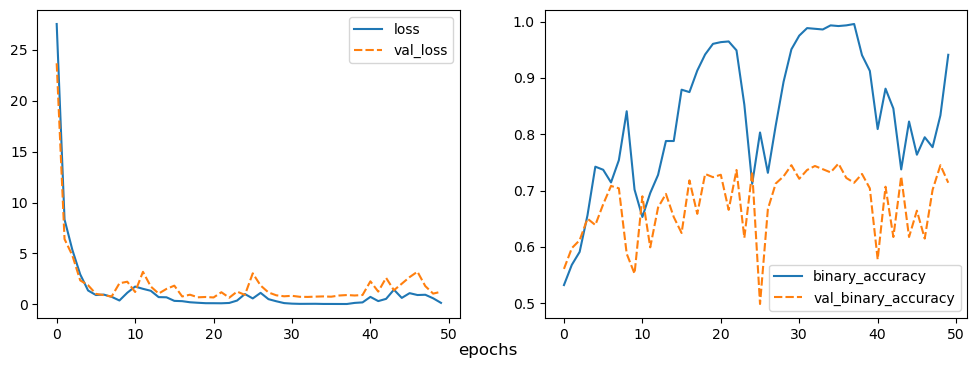

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## increase hidden layers

In [128]:
model=Sequential()
model.add(Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [129]:
# summary of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 100)               15052900  
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,063,101
Trainable params: 15,063,101
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [131]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [132]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 9s 624ms/step - loss: 9.7283 - binary_accuracy: 0.5243 - val_loss: 3.4952 - val_binary_accuracy: 0.6048
Epoch 2/50
13/13 [==============================] - 4s 334ms/step - loss: 2.3564 - binary_accuracy: 0.5990 - val_loss: 1.3966 - val_binary_accuracy: 0.6161
Epoch 3/50
13/13 [==============================] - 4s 292ms/step - loss: 1.3955 - binary_accuracy: 0.6361 - val_loss: 1.7865 - val_binary_accuracy: 0.5482
Epoch 4/50
13/13 [==============================] - 4s 333ms/step - loss: 0.9197 - binary_accuracy: 0.6974 - val_loss: 0.9019 - val_binary_accuracy: 0.6572
Epoch 5/50
13/13 [==============================] - 5s 356ms/step - loss: 0.6697 - binary_accuracy: 0.7242 - val_loss: 0.7301 - val_binary_accuracy: 0.6771
Epoch 6/50
13/13 [==============================] - 7s 533ms/step - loss: 0.6015 - binary_accuracy: 0.7473 - val_loss: 0.5582 - val_binary_accuracy: 0.7238
Epoch 7/50
13/13 [==============================] - 4s 307ms/ste

In [133]:
model = load_model('vehicle_model.h5')

In [134]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 24ms/step


In [135]:
prediction_cat = (prediction >= 0.5).astype(int)

In [136]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       396
           1       0.78      0.60      0.68       310

    accuracy                           0.75       706
   macro avg       0.76      0.73      0.74       706
weighted avg       0.75      0.75      0.74       706



In [137]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

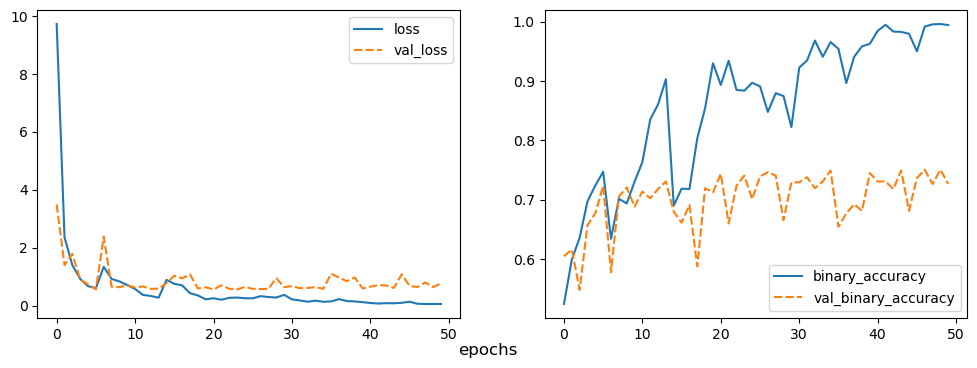

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

## change hidden neurons

In [150]:
model=Sequential()
model.add(Dense(units=25, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [151]:
# summary of the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 25)                3763225   
                                                                 
 dense_24 (Dense)            (None, 25)                650       
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,763,901
Trainable params: 3,763,901
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [153]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=50, mode='max', baseline=0.5),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)]

In [154]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 7s 498ms/step - loss: 1.6905 - binary_accuracy: 0.5541 - val_loss: 0.6369 - val_binary_accuracy: 0.6501
Epoch 2/50
13/13 [==============================] - 2s 129ms/step - loss: 0.7342 - binary_accuracy: 0.6409 - val_loss: 0.5948 - val_binary_accuracy: 0.6827
Epoch 3/50
13/13 [==============================] - 1s 114ms/step - loss: 0.5474 - binary_accuracy: 0.7363 - val_loss: 0.6087 - val_binary_accuracy: 0.6870
Epoch 4/50
13/13 [==============================] - 2s 122ms/step - loss: 0.5618 - binary_accuracy: 0.7375 - val_loss: 0.9917 - val_binary_accuracy: 0.5751
Epoch 5/50
13/13 [==============================] - 2s 129ms/step - loss: 0.5948 - binary_accuracy: 0.7035 - val_loss: 0.5610 - val_binary_accuracy: 0.7082
Epoch 6/50
13/13 [==============================] - 1s 117ms/step - loss: 0.4868 - binary_accuracy: 0.7776 - val_loss: 0.5405 - val_binary_accuracy: 0.7139
Epoch 7/50
13/13 [==============================] - 1s 112ms/ste

In [155]:
model = load_model('vehicle_model.h5')

In [156]:
prediction = model.predict(X_test)

23/23 [==============================] - 0s 12ms/step


In [157]:
prediction_cat = (prediction >= 0.5).astype(int)

In [158]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.82      0.72      0.76       396
           1       0.69      0.80      0.74       310

    accuracy                           0.75       706
   macro avg       0.75      0.76      0.75       706
weighted avg       0.76      0.75      0.75       706



In [159]:
history_df = pd.DataFrame(history.history)

Text(0.5, 0.01, 'epochs')

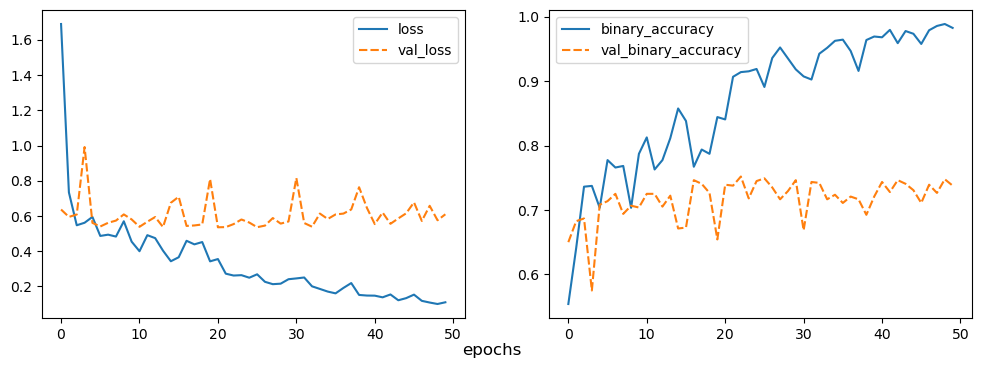

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')